In [8]:
from experiments.mmvae.mnist import (
    mnist_audio_encoder, mnist_audio_decoder,
    mnist_image_encoder, mnist_image_decoder,
)
from reconstruct.mmvae import DecoupledMMVAE

import experiments.mmvae.mnist as mnist
import torch
import torch.nn as nn
import torch.optim as optim
device = 'cuda'

In [9]:
dataloader_config = {
    'batch_size' : 64,
    'shuffle': True, 
    'pin_memory' : True,
    'num_workers' : 2
}
dataloader = mnist.get_MNIST_dataloader(
    audio_path = '/root/audio_mnist',
    image_path = '/root/image_mnist',
    csv_path = 'mmMNIST.csv',
    trainloader_config = dataloader_config
)
audio, image, label = next(iter(dataloader))
len(dataloader.dataset)

30000

In [10]:
encoders = {
    'audio' : mnist_audio_encoder,
    'image' : mnist_image_encoder
}

decoders = {
    'audio' : mnist_audio_decoder,
    'image' : mnist_image_decoder
}

audio_criterion = nn.MSELoss(reduce=False, reduction='none')
image_criterion = nn.BCELoss(reduce=False, reduction='none')

def take_mean(x):
    B = x.shape[0]
    return x.view(B, -1).mean(dim=-1)

# score_fns = {
#     'audio' : lambda x_hat, x: take_mean(audio_criterion(x_hat, x)),
#     'image' : lambda x_hat, x: take_mean(image_criterion(x_hat, x))
# }

score_fns = {
    'audio' : nn.MSELoss(),
    'image' : nn.BCELoss()
}

model = DecoupledMMVAE(
    encoders=encoders,
    decoders=decoders,
    latent_dim=32,
    score_fns=score_fns
).to(device)

/root/miniconda3/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [11]:
ckp = torch.load('./un-estimate.pt')
model.load_state_dict(ckp['model'])

<All keys matched successfully>

In [ ]:
from utils import vanilla_trainer
from collections import OrderedDict

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
penalty = {
    'audio' : 1.0,
    'image' : 1.0
}

def unpack_and_forward(model, inputs):
    audio, image, _ = inputs
    # image = image.reshape(image.shape[0], -1)
    x = {
        'audio' : audio.to(device),
        'image' : image.to(device)
    }
    nelbo, kl, rec, verbose_output = model(x, alpha=0.001, rsample=5, mod_penalty=penalty, iw_cross_mod=False, verbose=True)
    prompt = {
        'nelbo' : nelbo.item(),
        'kl' : kl.item(),
        'rec' : rec.item()
    }
    for k, v in verbose_output.items():
        prompt[k] = v.item()
        
    return nelbo, prompt

vanilla_trainer(
    model, dataloader,
    optimizer, None,
    100, 
    device,
    unpack_and_forward,
    do_autoencode=False,
    custom_prompt=True,
    use_tensorboard=True,
    tensorboard_path='/root/tf-logs',
    save_path='un-estimate.pt'
)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

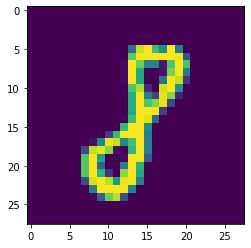

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def display_image(image, channel_first=True, cmap='viridis'):
    if len(image.shape) == 3:
        if channel_first:
            image = np.rollaxis(image, 0, image.ndim)
        if image.shape[-1] == 1:
            image = image.squeeze()
            
    plt.imshow(image, cmap=cmap)

audio, image , _ = dataloader.dataset[25000]
display_image(image.cpu().numpy())


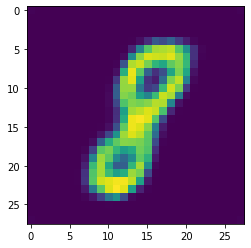

In [19]:
from utils.visual import draw_histogram, display_mel_as_wave
from reconstruct._utils.audio import save_mel_as_wav

inputs = {
    'image' : image.cuda().unsqueeze(0)
    # 'audio' : audio.cuda().unsqueeze(0)
}
model.eval()
rec = model.reconstruct(inputs)
std = 17.8
mean = -57

def mel_denormalize(logmelspec):
    logmel = (logmelspec * std) + mean
    melspec = np.power(10, logmel / 10)
    return melspec

def tensor2np(t):
    return t.detach().cpu().numpy()

def get_ready(data):

    return mel_denormalize(
        tensor2np(data)
    )

save_mel_as_wav(get_ready(rec['audio'].squeeze()), save_path='./rec.wav')

display_image(rec['image'].detach().cpu().squeeze(0).numpy())